In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel

## 1 . Data Preprocessing and Exploration


In [2]:
# Create HIGGS_sample from HIGGS dataset; to do later

In [3]:
# Load HIGGS_sample

filepath = "./HIGGS_sample.csv"
read_data = pd.read_csv(filepath)
data = read_data.drop(columns=['1.000000000000000000e+00'])
target = read_data['1.000000000000000000e+00']

### 1.1 Exploratory Data Analysis (EDA)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   8.692932128906250000e-01    110000 non-null  float64
 1   -6.350818276405334473e-01   110000 non-null  float64
 2   2.256902605295181274e-01    110000 non-null  float64
 3   3.274700641632080078e-01    110000 non-null  float64
 4   -6.899932026863098145e-01   110000 non-null  float64
 5   7.542022466659545898e-01    110000 non-null  float64
 6   -2.485731393098831177e-01   110000 non-null  float64
 7   -1.092063903808593750e+00   110000 non-null  float64
 8   0.000000000000000000e+00    110000 non-null  float64
 9   1.374992132186889648e+00    110000 non-null  float64
 10  -6.536741852760314941e-01   110000 non-null  float64
 11  9.303491115570068359e-01    110000 non-null  float64
 12  1.107436060905456543e+00    110000 non-null  float64
 13  1.138904333114

In [5]:
data.describe()  # summary statistics

,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,...,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,...,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,0.993285,-0.005985,-0.002650,0.998366,0.001416,0.990549,0.003786,-0.006673,1.004337,0.992307,...,-0.000581,0.000222,0.994672,1.032670,1.025995,1.050662,1.011109,0.975567,1.034330,0.961325
std,0.569758,1.007981,1.004571,0.603324,1.007990,0.476472,1.012672,1.007398,1.027857,0.496715,...,1.009341,1.005146,1.399653,0.674207,0.382991,0.162497,0.399684,0.527061,0.366120,0.315269
min,0.274697,-2.434976,-1.742508,0.001690,-1.743932,0.157473,-2.969725,-1.741237,0.000000,0.189359,...,-2.497265,-1.742691,0.000000,0.101603,0.297987,0.234146,0.292503,0.067156,0.340333,0.370761
25%,0.591119,-0.746114,-0.872486,0.575659,-0.871000,0.679084,-0.687245,-0.879738,0.000000,0.657342,...,-0.710026,-0.870924,0.000000,0.789034,0.846460,0.985767,0.769028,0.675868,0.820544,0.771713
50%,0.852639,-0.007846,-0.003570,0.889777,0.000287,0.894270,0.005916,-0.008257,1.086538,0.892278,...,-0.002959,-0.001374,0.000000,0.894816,0.951576,0.989783,0.916808,0.874679,0.948435,0.873488
75%,1.238789,0.734318,0.864890,1.291532,0.877119,1.167351,0.692145,0.861660,2.173076,1.204141,...,0.715767,0.869941,3.101961,1.025956,1.084873,1.021725,1.144072,1.139780,1.141846,1.059154
max,8.790659,2.434868,1.743236,11.531485,1.743257,7.419452,2.966703,1.741454,2.173076,7.464693,...,2.498009,1.743372,3.101961,18.002125,9.153964,3.954101,8.140121,8.835245,6.775816,5.111963


In [6]:
data.nunique()  # number of unique values in each column

8.692932128906250000e-01       13435
-6.350818276405334473e-01       4934
2.256902605295181274e-01        6284
3.274700641632080078e-01      103448
-6.899932026863098145e-01     103560
7.542022466659545898e-01       21082
-2.485731393098831177e-01       5768
-1.092063903808593750e+00       6284
0.000000000000000000e+00           3
1.374992132186889648e+00       16990
-6.536741852760314941e-01       5859
9.303491115570068359e-01        6284
1.107436060905456543e+00           3
1.138904333114624023e+00       12757
-1.578198313713073730e+00       5937
-1.046985387802124023e+00       6284
0.000000000000000000e+00.1         3
6.579295396804809570e-01        9613
-1.045456994324922562e-02       5987
-4.576716944575309753e-02       6284
3.101961374282836914e+00           3
1.353760004043579102e+00       99448
9.795631170272827148e-01       74371
9.780761599540710449e-01       49334
9.200048446655273438e-01       84054
7.216574549674987793e-01       90893
9.887509346008300781e-01       91767
8

In [7]:
data.isnull().sum()  # number of missing values in each column

8.692932128906250000e-01      0
-6.350818276405334473e-01     0
2.256902605295181274e-01      0
3.274700641632080078e-01      0
-6.899932026863098145e-01     0
7.542022466659545898e-01      0
-2.485731393098831177e-01     0
-1.092063903808593750e+00     0
0.000000000000000000e+00      0
1.374992132186889648e+00      0
-6.536741852760314941e-01     0
9.303491115570068359e-01      0
1.107436060905456543e+00      0
1.138904333114624023e+00      0
-1.578198313713073730e+00     0
-1.046985387802124023e+00     0
0.000000000000000000e+00.1    0
6.579295396804809570e-01      0
-1.045456994324922562e-02     0
-4.576716944575309753e-02     0
3.101961374282836914e+00      0
1.353760004043579102e+00      0
9.795631170272827148e-01      0
9.780761599540710449e-01      0
9.200048446655273438e-01      0
7.216574549674987793e-01      0
9.887509346008300781e-01      0
8.766783475875854492e-01      0
dtype: int64

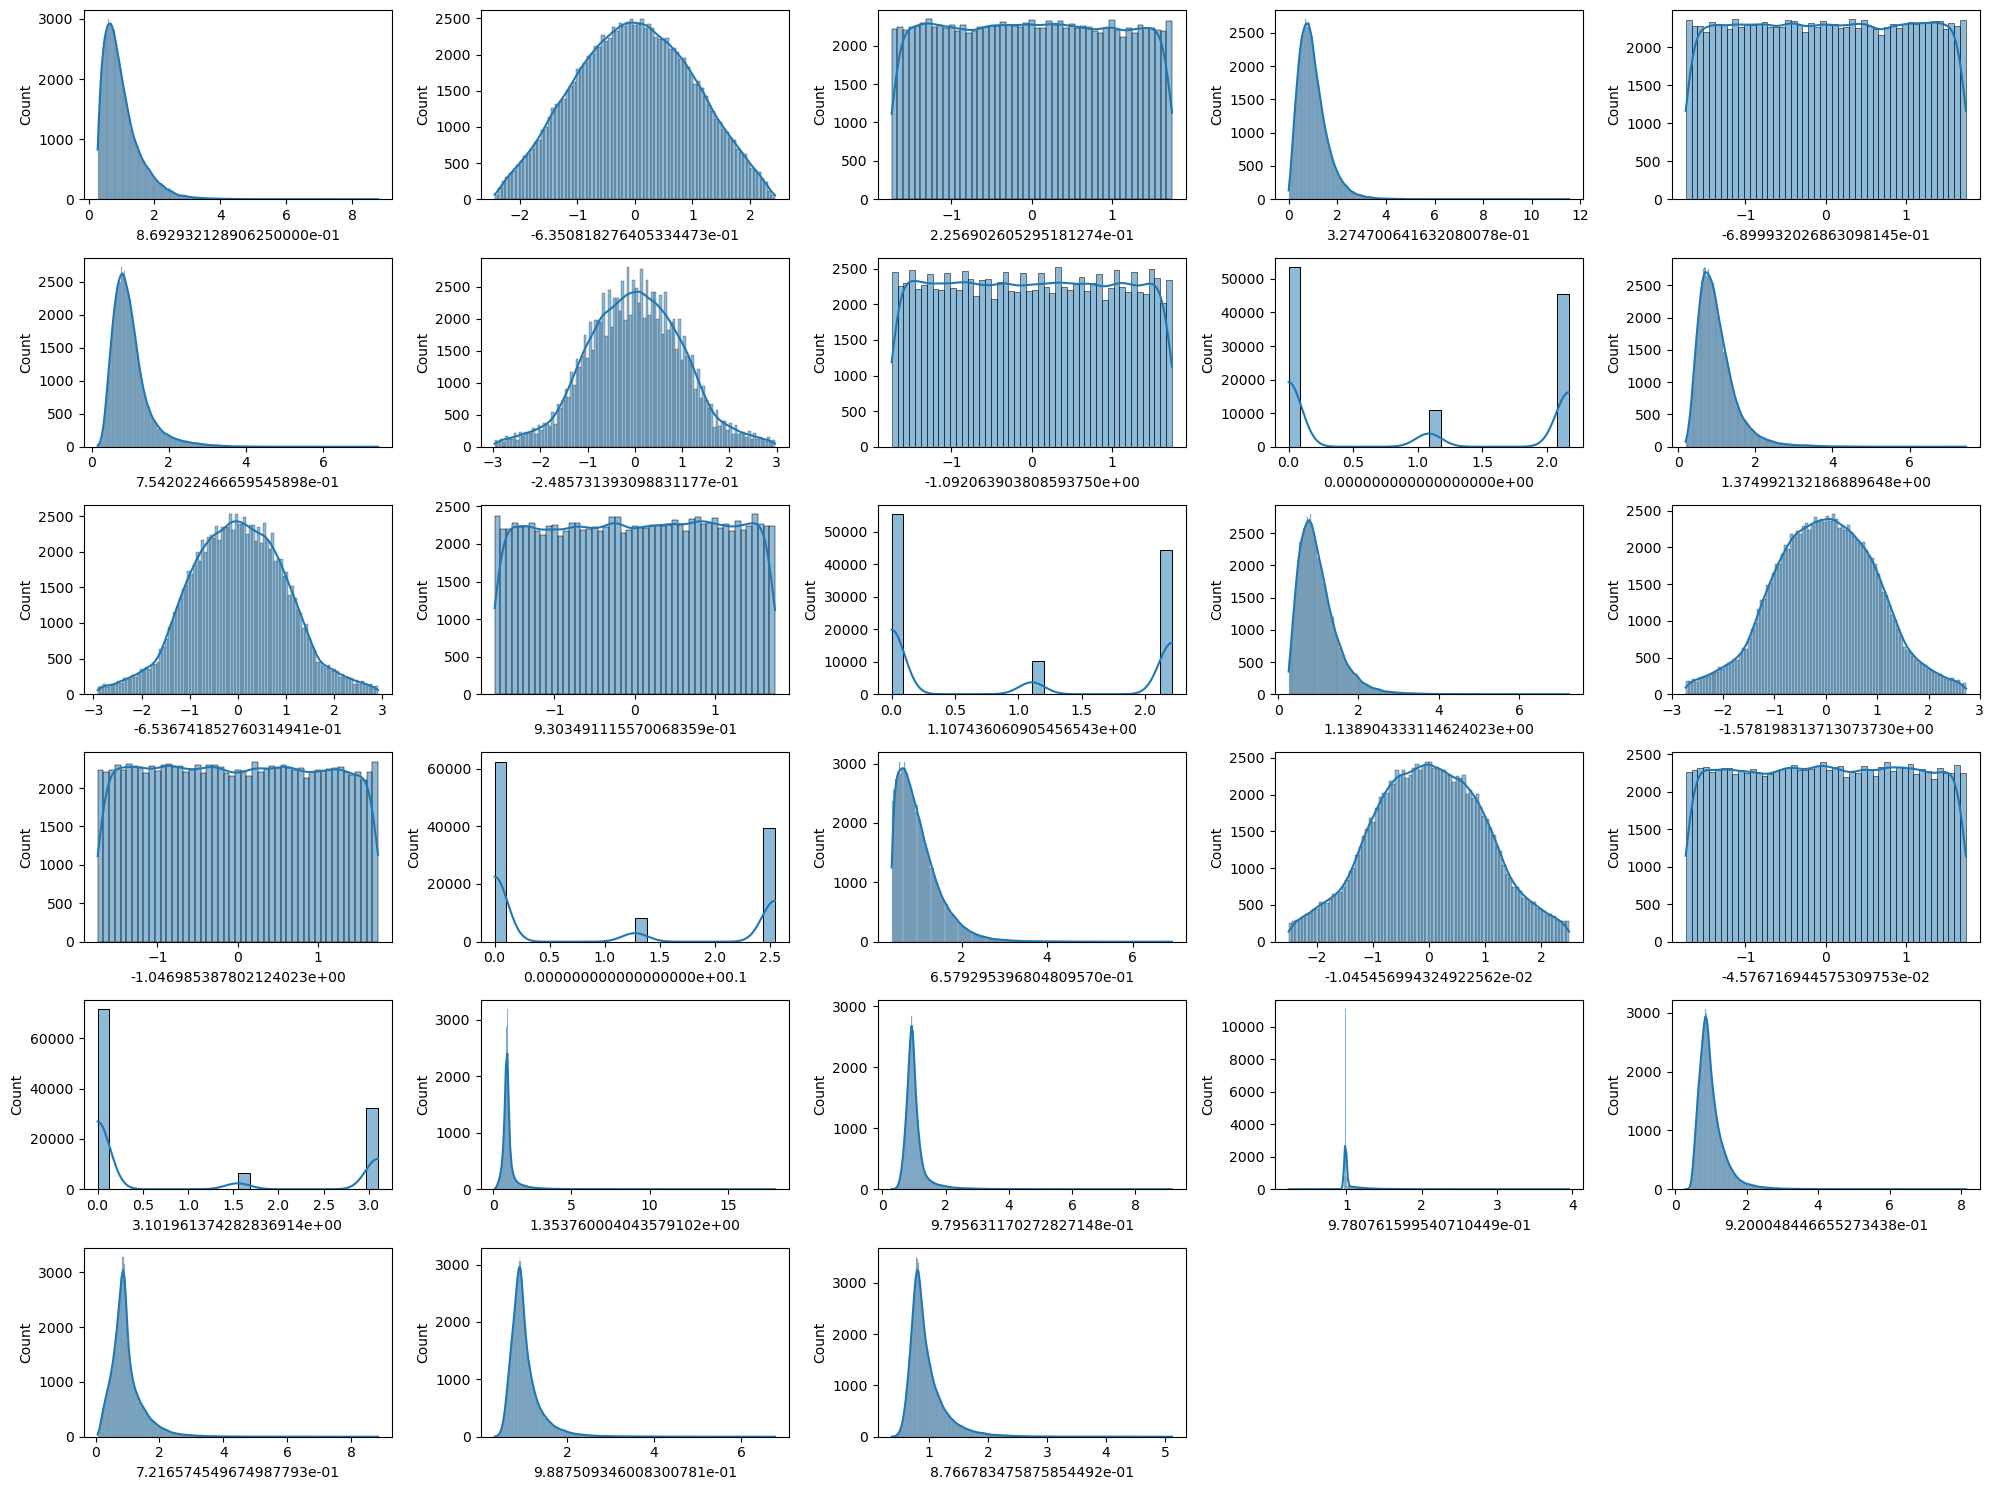

In [8]:
def beautiful_plot(df):
    plt.figure(figsize=(20, 15))
    rows, cols = (df.shape[1] + 4) // 5, 5

    for idx, column in enumerate(df.columns):
        plt.subplot(rows, cols, idx + 1)
        sns.histplot(df[column], kde=True)

    plt.tight_layout()
    plt.show()


beautiful_plot(data)

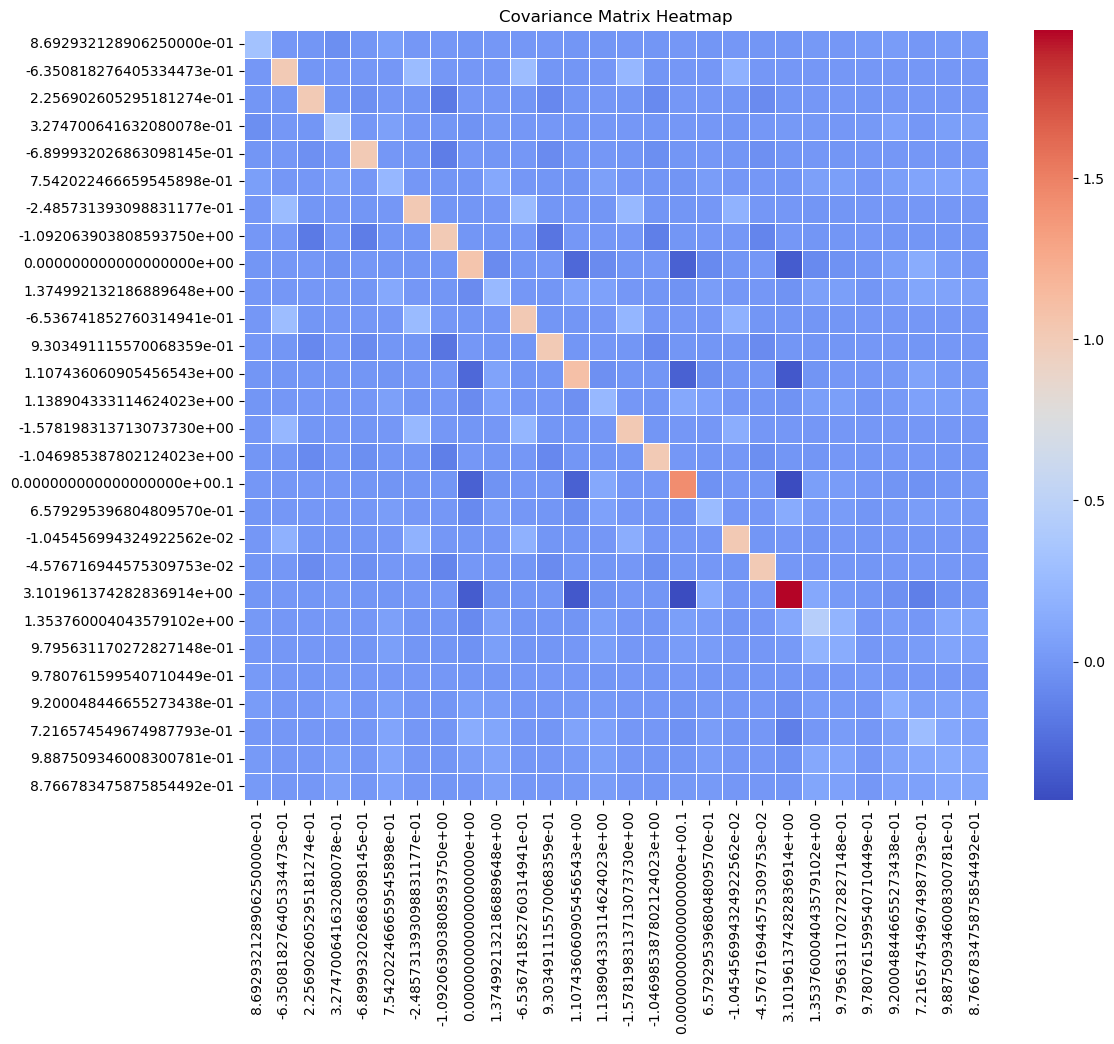

In [9]:
cov_matrix = data.cov()

plt.figure(figsize=(12, 10))

sns.heatmap(cov_matrix, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [10]:
outliers = {}

for column in data.columns:
    skewness = data[column].skew()

    if abs(skewness) < 0.5:  # Approximately normal - Use Z-score
        threshold = 3
        z_scores = zscore(data[column].dropna())
        outliers[column] = data[column][np.abs(z_scores) > threshold]
        print(f"{column}: Z-score method detected {len(outliers[column])} outliers")
    else:  # Skewed or non-normal - Use IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers[column] = data[column][
            (data[column] < Q1 - 2 * IQR) | (data[column] > Q3 + 1.5 * IQR)
        ]
        print(f"{column}: IQR method detected {len(outliers[column])} outliers")

8.692932128906250000e-01: IQR method detected 4353 outliers
-6.350818276405334473e-01: Z-score method detected 0 outliers
2.256902605295181274e-01: Z-score method detected 0 outliers
3.274700641632080078e-01: IQR method detected 3288 outliers
-6.899932026863098145e-01: Z-score method detected 0 outliers
7.542022466659545898e-01: IQR method detected 5499 outliers
-2.485731393098831177e-01: Z-score method detected 0 outliers
-1.092063903808593750e+00: Z-score method detected 0 outliers
0.000000000000000000e+00: Z-score method detected 0 outliers
1.374992132186889648e+00: IQR method detected 4293 outliers
-6.536741852760314941e-01: Z-score method detected 0 outliers
9.303491115570068359e-01: Z-score method detected 0 outliers
1.107436060905456543e+00: Z-score method detected 0 outliers
1.138904333114624023e+00: IQR method detected 3540 outliers
-1.578198313713073730e+00: Z-score method detected 0 outliers
-1.046985387802124023e+00: Z-score method detected 0 outliers
0.000000000000000000e+

### 1.2 Data Normalization/Standardization

"Input features were standardized over the entire train/test set with mean zero and standard deviation one, except for those features with values strictly greater than zero – these we scaled so that the mean value was one."
~ [Searching for Exotic Particles in High-Energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735)


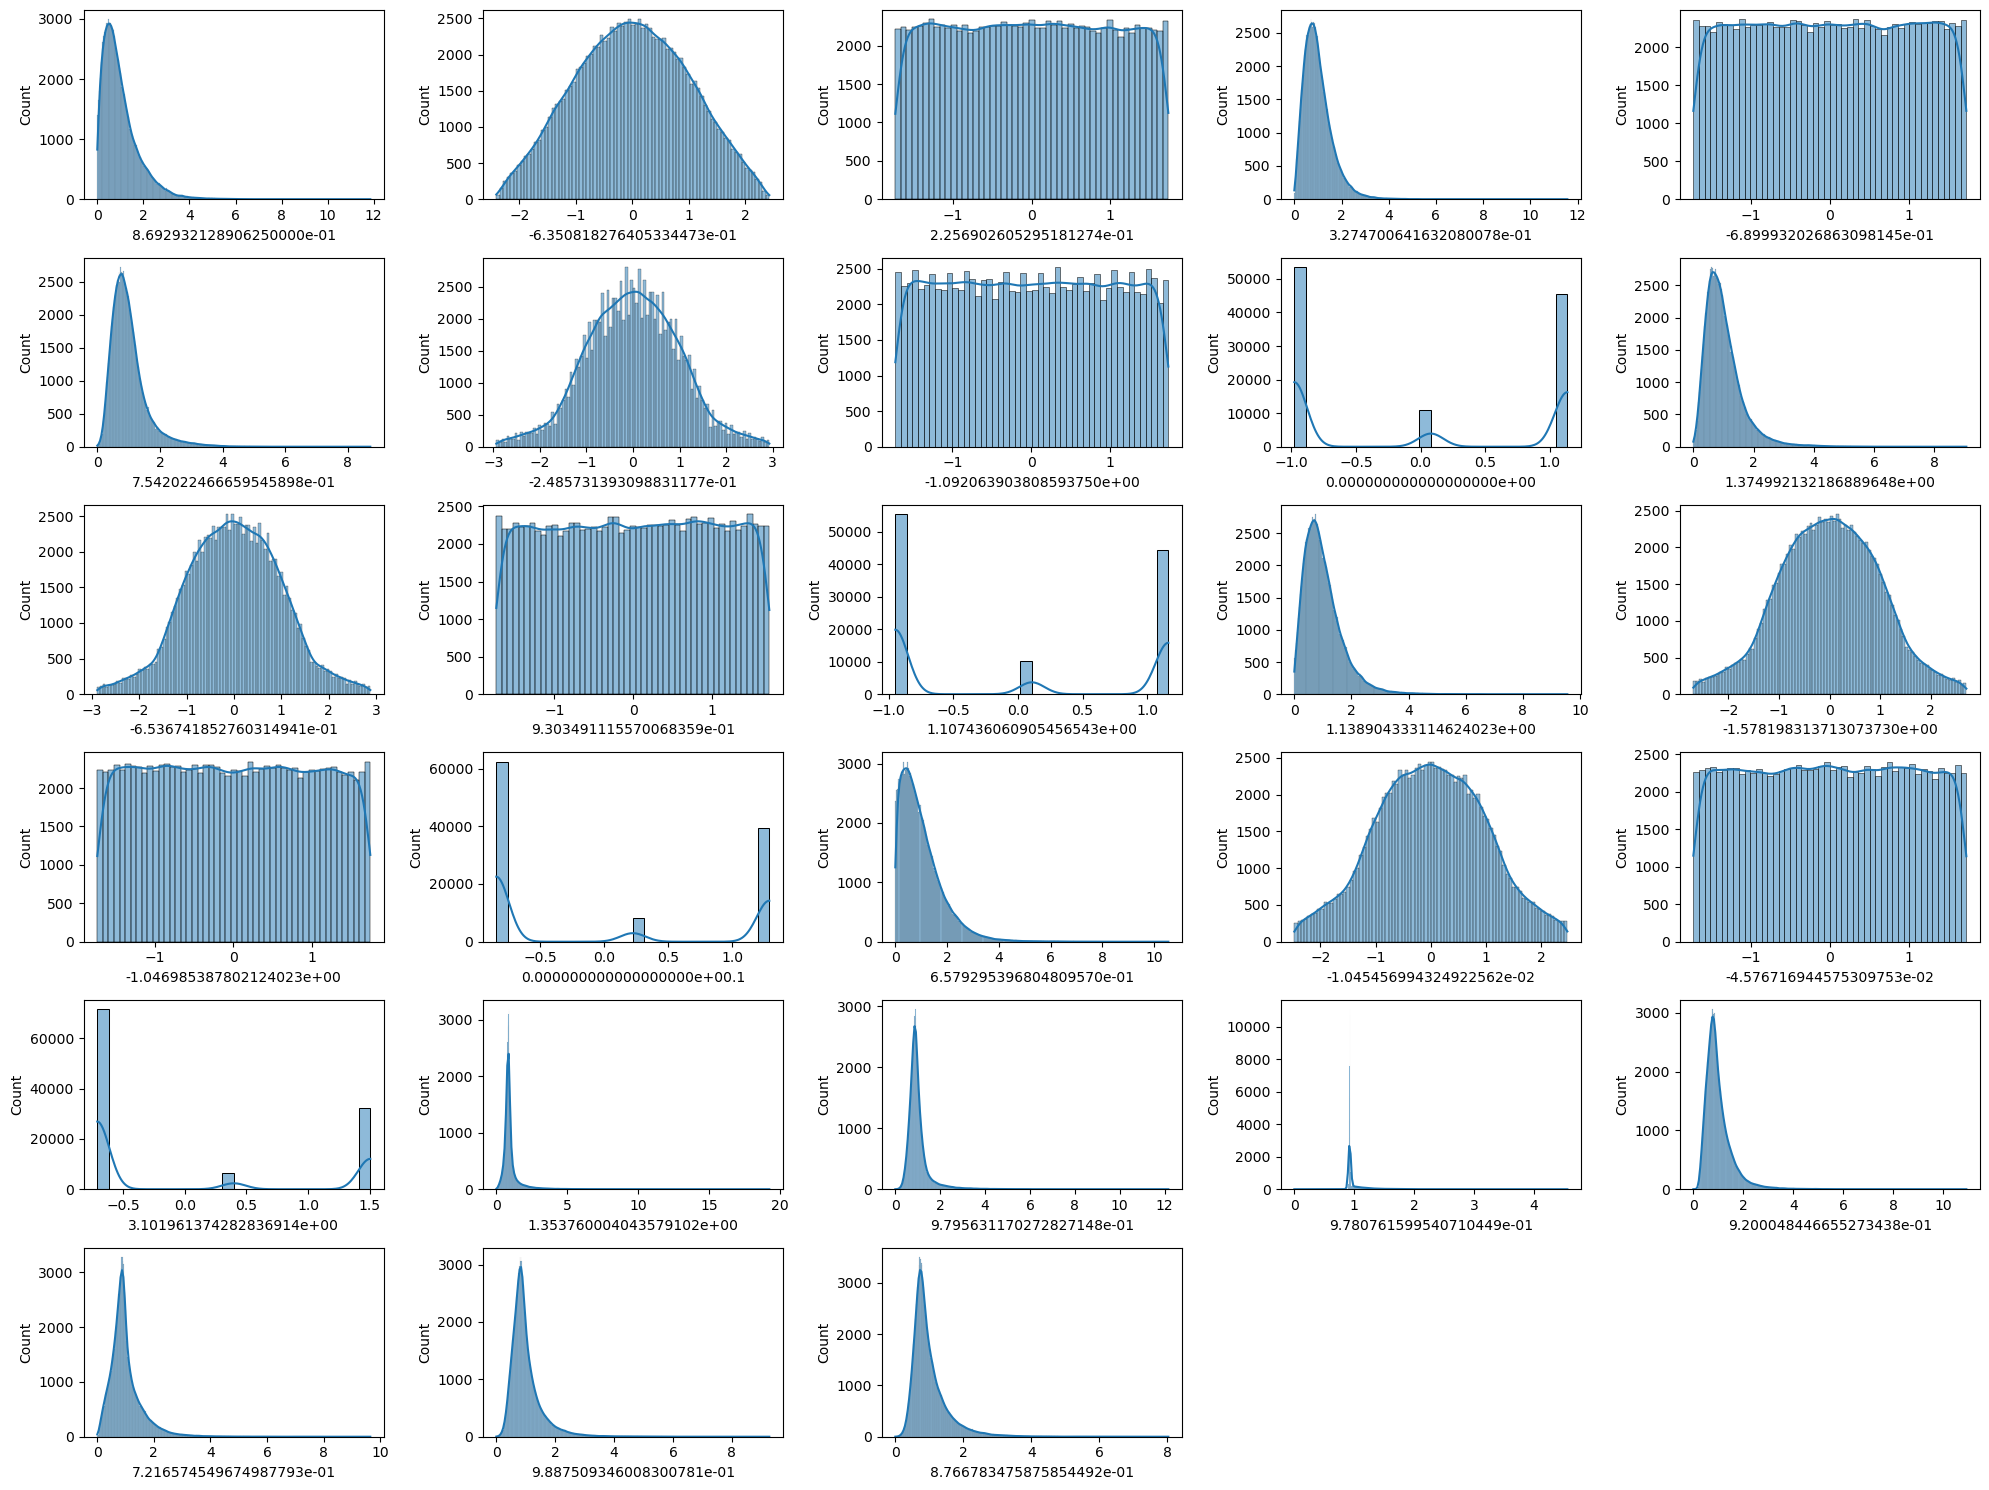

In [11]:
# Identify columns with strictly positive values
positive_only_columns = [col for col in data.columns if (data[col] > 0).all()]

# Separate data into positive-only and other columns
data_positive_only = data[positive_only_columns]
data_other = data.drop(columns=positive_only_columns)

# Standardize columns with both positive and negative values
scaler = StandardScaler()
data_other_scaled = scaler.fit_transform(data_other)
data_other_scaled = pd.DataFrame(data_other_scaled, columns=data_other.columns)

# Scale positive-only columns so the mean is 1
scaler_positive = MinMaxScaler()
data_positive_only_scaled = scaler_positive.fit_transform(data_positive_only)
data_positive_only_scaled = pd.DataFrame(
    data_positive_only_scaled, columns=data_positive_only.columns
)
data_positive_only_scaled = data_positive_only_scaled * (
    1 / data_positive_only_scaled.mean()
)

# Combine both scaled parts back into a single DataFrame
data_scaled = pd.concat([data_other_scaled, data_positive_only_scaled], axis=1)
data_scaled = data_scaled[data.columns]  # Reorder columns to match original data order

# Plot the histograms of each feature
beautiful_plot(data_scaled)

### 1.3 Feature Engineering

In [12]:
# Generate only interaction terms (no powers)
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = interaction.fit_transform(data_scaled)

# Convert to DataFrame
interaction_feature_names = interaction.get_feature_names_out(data_scaled.columns)
data_interactions = pd.DataFrame(interaction_features, columns=interaction_feature_names)

data_interactions.describe()

,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,...,9.780761599540710449e-01 9.200048446655273438e-01,9.780761599540710449e-01 7.216574549674987793e-01,9.780761599540710449e-01 9.887509346008300781e-01,9.780761599540710449e-01 8.766783475875854492e-01,9.200048446655273438e-01 7.216574549674987793e-01,9.200048446655273438e-01 9.887509346008300781e-01,9.200048446655273438e-01 8.766783475875854492e-01,7.216574549674987793e-01 9.887509346008300781e-01,7.216574549674987793e-01 8.766783475875854492e-01,9.887509346008300781e-01 8.766783475875854492e-01
count,110000.000000,1.100000e+05,1.100000e+05,110000.000000,1.100000e+05,110000.000000,1.100000e+05,1.100000e+05,1.100000e+05,110000.000000,...,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,1.000000,2.196223e-18,3.100550e-17,1.000000,-2.041195e-17,1.000000,-2.325413e-18,-3.966120e-17,7.880565e-17,1.000000,...,1.012832,1.000100,1.003507,1.004701,1.093853,1.167425,1.163445,1.170552,1.128465,1.252100
std,0.792885,1.000005e+00,1.000005e+00,0.605336,1.000005e+00,0.571943,1.000005e+00,1.000005e+00,1.000005e+00,0.618614,...,0.653964,0.633121,0.596785,0.607761,1.352566,1.612728,1.547343,1.559704,1.401197,1.860432
min,0.000000,-2.409770e+00,-1.731949e+00,0.000000,-1.731520e+00,0.000000,-2.936316e+00,-1.721835e+00,-9.771211e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440339,-7.342727e-01,-8.658814e-01,0.575883,-8.655039e-01,0.626127,-6.823867e-01,-8.666579e-01,-9.771211e-01,0.582831,...,0.631916,0.649050,0.666543,0.649359,0.468754,0.480175,0.473051,0.479220,0.482588,0.477335
50%,0.804275,-1.846488e-03,-9.156950e-04,0.891049,-1.119733e-03,0.884430,2.103696e-03,-1.572975e-03,7.997405e-02,0.875423,...,0.846644,0.861229,0.854581,0.840287,0.794643,0.778551,0.763807,0.785804,0.759314,0.741484
75%,1.341648,7.344448e-01,8.635974e-01,1.294144,8.687658e-01,1.212228,6.797492e-01,8.619602e-01,1.137069e+00,1.263820,...,1.204869,1.192405,1.164488,1.176018,1.300695,1.298415,1.304617,1.313100,1.284708,1.323743
max,11.850965,2.421538e+00,1.737950e+00,11.568250,1.728042e+00,8.717069,2.925856e+00,1.735297e+00,1.137069e+00,9.060777,...,20.809648,20.404182,24.568983,23.161345,58.944958,73.086856,61.621336,59.211187,55.818781,71.130838


In [13]:
# Combine original and interaction features
data_engineered = pd.concat([data_scaled, data_interactions], axis=1)

### 1.4 Feature Selection

In [14]:
data_engineered.columns

Index(['8.692932128906250000e-01', '-6.350818276405334473e-01',
       '2.256902605295181274e-01', '3.274700641632080078e-01',
       '-6.899932026863098145e-01', '7.542022466659545898e-01',
       '-2.485731393098831177e-01', '-1.092063903808593750e+00',
       '0.000000000000000000e+00', '1.374992132186889648e+00',
       ...
       '9.780761599540710449e-01 9.200048446655273438e-01',
       '9.780761599540710449e-01 7.216574549674987793e-01',
       '9.780761599540710449e-01 9.887509346008300781e-01',
       '9.780761599540710449e-01 8.766783475875854492e-01',
       '9.200048446655273438e-01 7.216574549674987793e-01',
       '9.200048446655273438e-01 9.887509346008300781e-01',
       '9.200048446655273438e-01 8.766783475875854492e-01',
       '7.216574549674987793e-01 9.887509346008300781e-01',
       '7.216574549674987793e-01 8.766783475875854492e-01',
       '9.887509346008300781e-01 8.766783475875854492e-01'],
      dtype='object', length=434)

In [15]:
# Initialize SelectKBest to select the top 50 features
select_kbest = SelectKBest(score_func=f_classif, k=50)
select_kbest.fit(data_engineered, target)

# Get the selected features
selected_features_kbest = data_engineered.columns[select_kbest.get_support()]
data_reduced = data_engineered[list(selected_features_kbest)]
data_reduced.describe()

,3.274700641632080078e-01,3.274700641632080078e-01,1.107436060905456543e+00,1.107436060905456543e+00,7.216574549674987793e-01,7.216574549674987793e-01,9.887509346008300781e-01,9.887509346008300781e-01,8.766783475875854492e-01,8.766783475875854492e-01,...,9.795631170272827148e-01 7.216574549674987793e-01,9.780761599540710449e-01 7.216574549674987793e-01,9.780761599540710449e-01 9.887509346008300781e-01,9.780761599540710449e-01 8.766783475875854492e-01,9.200048446655273438e-01 7.216574549674987793e-01,9.200048446655273438e-01 9.887509346008300781e-01,9.200048446655273438e-01 8.766783475875854492e-01,7.216574549674987793e-01 9.887509346008300781e-01,7.216574549674987793e-01 8.766783475875854492e-01,9.887509346008300781e-01 8.766783475875854492e-01
count,110000.000000,110000.000000,1.100000e+05,1.100000e+05,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,...,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,1.000000,1.000000,-1.251686e-16,-1.251686e-16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.045600,1.000100,1.003507,1.004701,1.093853,1.167425,1.163445,1.170552,1.128465,1.252100
std,0.605336,0.605336,1.000005e+00,1.000005e+00,0.580202,0.580202,0.527553,0.527553,0.533844,0.533844,...,1.089706,0.633121,0.596785,0.607761,1.352566,1.612728,1.547343,1.559704,1.401197,1.860432
min,0.000000,0.000000,-9.485294e-01,-9.485294e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.575883,0.575883,-9.485294e-01,-9.485294e-01,0.670084,0.670084,0.691949,0.691949,0.678930,0.678930,...,0.529381,0.649050,0.666543,0.649359,0.468754,0.480175,0.473051,0.479220,0.482588,0.477335
50%,0.891049,0.891049,-9.485294e-01,-9.485294e-01,0.888941,0.888941,0.876231,0.876231,0.851266,0.851266,...,0.806127,0.861229,0.854581,0.840287,0.794643,0.778551,0.763807,0.785804,0.759314,0.741484
75%,1.294144,1.294144,1.163709e+00,1.163709e+00,1.180770,1.180770,1.154923,1.154923,1.165653,1.165653,...,1.207482,1.192405,1.164488,1.176018,1.300695,1.298415,1.304617,1.313100,1.284708,1.323743
max,11.568250,11.568250,1.163709e+00,1.163709e+00,9.652124,9.652124,9.273072,9.273072,8.028259,8.028259,...,40.345088,20.404182,24.568983,23.161345,58.944958,73.086856,61.621336,59.211187,55.818781,71.130838


## 2. Linear SVM Implementation

### 2.1 SVM with a linear kernel (mini-batch learning)

In [21]:
# Sample 10% of data for the mini batch, keeping class distribution
data_sampled, _, target_sampled, _ = train_test_split(data_reduced, target, train_size=0.1, stratify=target, random_state=42)

In [22]:
# Initialize the linear SVM model
svm = SVC(kernel='linear', probability=True, random_state=42)

# Define cross-validation strategy (e.g., Stratified K-Folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr', response_method="predict_proba")
}

# Perform cross-validation
cv_results = cross_validate(svm, data_sampled, target_sampled, cv=cv, scoring=scoring)

# Calculate and print mean metrics across all folds
print("SVM (Linear Kernel) Performance Metrics:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f}")
print(f"AUC (Area Under the ROC Curve): {cv_results['test_roc_auc'].mean():.4f}")

SVM (Linear Kernel) Performance Metrics:
Accuracy: 0.6516
Precision: 0.6637
Recall: 0.6516
F1 Score: 0.6383
AUC (Area Under the ROC Curve): 0.7016


### 2.2 Stochastic Gradient Descent (SGD)

In [23]:
# Initialize the SGDClassifier with a linear SVM loss function
sgd_clf = SGDClassifier(loss='hinge', random_state=42, max_iter=1000)

# Cross-validation for performance assessment
cv_scores = cross_val_score(sgd_clf, data_reduced, target, cv=5, scoring='accuracy')
print("SGDClassifier Accuracy:", cv_scores.mean())

SGDClassifier Accuracy: 0.6431181818181818


## 3. SVM with Polynomial, RBF, and Custom Kernels

### 3.1 Polynomial Kernel

In [24]:
# Polynomial Kernel with varying degrees
poly_results = {}
for degree in [2, 3, 4]:
    poly_svm = SVC(kernel='poly', degree=degree, random_state=42)
    scores = cross_val_score(poly_svm, data_sampled, target_sampled, cv=5, scoring='accuracy')
    poly_results[degree] = scores.mean()
    print(f"Polynomial Kernel (degree={degree}) Accuracy: {scores.mean():.4f}")

Polynomial Kernel (degree=2) Accuracy: 0.6315
Polynomial Kernel (degree=3) Accuracy: 0.6240
Polynomial Kernel (degree=4) Accuracy: 0.6153


### 3.2 RBF Kernel

In [28]:
# RBF Kernel with varying gamma
rbf_results = {}
for gamma in [0.01, 0.1, 1, 10]:
    rbf_svm = SVC(kernel='rbf', gamma=gamma, random_state=42)
    scores = cross_val_score(rbf_svm, data_sampled, target_sampled, cv=5, scoring='accuracy')
    rbf_results[gamma] = scores.mean()
    print(f"RBF Kernel (gamma={gamma}) Accuracy: {scores.mean():.4f}")

RBF Kernel (gamma=0.01) Accuracy: 0.6794
RBF Kernel (gamma=0.1) Accuracy: 0.6824
RBF Kernel (gamma=1) Accuracy: 0.5736
RBF Kernel (gamma=10) Accuracy: 0.5282


### 3.3 Custom Kernel

In [ ]:
# Define a custom kernel function that combines RBF and linear kernels
def hybrid_kernel(X, Y):
    gamma = 0.1  # Hyperparameter for RBF component
    alpha = 0.5  # Weight for combining the two kernels
    rbf_part = rbf_kernel(X, Y, gamma=gamma)
    linear_part = linear_kernel(X, Y)
    return alpha * rbf_part + (1 - alpha) * linear_part

# SVM with custom hybrid kernel
custom_svm = SVC(kernel=hybrid_kernel, random_state=42)
scores = cross_val_score(custom_svm, data_sampled, target_sampled, cv=5, scoring='accuracy')
print(f"Custom Hybrid Kernel Accuracy: {scores.mean():.4f}")

Custom Hybrid Kernel Accuracy: 0.6924
